# Animal classification using CNN, ResNet, MobileNet

We use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!




In [ ]:
### Animal Classification Competition
### Final Results:
### ACC: 90.3%        FLOPs: 752% per Gflops
##################################################################################################################################

In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/Computer Vision/Assignment 3/dataset'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
            transforms.RandomRotation(degrees=15)
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [ ]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ailurus-fulgens (5)


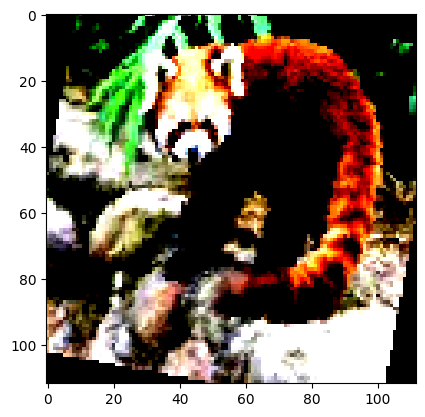

In [ ]:
show_image(*dataset[200])

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [ ]:

batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

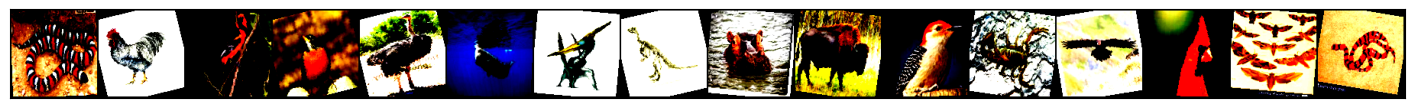

In [ ]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target):   # target is labels # output.shape: torch.Size([16, 151])
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top three guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        # .topk() is a built-in function in PyTorch
        _, pred = output.topk(maxk, 1, True, True) # tensor containing the indices of the top-3 elements
        pred = pred.t() #  transposes the pred tensor, from (16,3) to (3,16)
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        correct = (pred == target.view(1, -1).expand_as(pred))
        # correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions by calling forward pass
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def testing_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*112*112
output_size = 151

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [ ]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0284, -4.9991, -4.9557, -5.0721, -5.0665, -5.0017, -4.9961, -5.0013,
        -5.0690, -5.0141, -5.0858, -4.9882, -4.9863, -5.0218, -5.0298, -5.0444,
        -5.0462, -5.0089, -5.0289, -5.0815, -5.0339, -5.0105, -5.0181, -4.9726,
        -4.9901, -4.9731, -4.9629, -5.0841, -5.0180, -4.9678, -4.9797, -5.0247,
        -5.0851, -5.0109, -5.0178, -4.9842, -5.0172, -4.9984, -4.9028, -5.0234,
        -5.0542, -5.0327, -5.0083, -5.0826, -4.9346, -5.0442, -5.0160, -5.0906,
        -5.0123, -4.9949, -5.0145, -5.0499, -4.9832, -5.0906, -5.0242, -5.0794,
        -5.0684, -5.0467, -5.0363, -4.9803, -5.0670, -5.0262, -5.0472, -5.0411,
        -5.0557, -4.9917, -5.0301, -5.0375, -5.0242, -5.0383, -5.0409, -5.0069,
        -5.0316, -5.0837, -5.0635, -5.0759, -5.0239, -4.9984, -5.0237, -4.9628,
        -5.0865, -4.9982, -5.0449, -4.9639, -4.9970, -4.9506, -5.0406, -5.0303,
        -5.0350, -5.0368, -5.0474, 

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)  # {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def evaluate_test(model, test_loader):
    model = to_device(model, device)
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.testing_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        if epoch == epochs-1:
            model.epoch_end(epoch, result)
        history.append(result)  # A list of dictionary with {'train_loss: 4.8380, val_loss: 4.6042, val_acc: 0.0906'} for each epoch
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.015676975250244, 'val_acc': 0.02500000037252903}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title('Validation accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_all(history):
    fig, ax = plt.subplots(1,2,figsize=[13,5])
    accuracies = [x['val_acc'] for x in history]
    ax[0].plot(accuracies, '-x')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('validation accuracy')
    ax[0].set_title('Validation accuracy vs. No. of epochs')

    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax[1].plot(train_losses, '-bx')
    ax[1].plot(val_losses, '-rx')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['Training', 'Validation'])
    ax[1].set_title('Loss vs. No. of epochs')
    plt.show()


### FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2023-08-10 12:50:38--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=ficd2mn09b1ekvsn8s8vd6rmhp; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=J5XnCrJYfOojAv%2FdhAUgboF%2F9vjUJmg1urOpCHMABR2AflCcb8Y9bgMbm%2FxyakMJGl6OzLrRBNv4XMf%2BG5NKpyB1neHEG694e4%2BIHMlXGRyy4sGIegKmeUkYogNhuvTY; expires=Fri, 11-Aug-2023 12:50:38 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 226.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-08-10 12:50:39 (1.01 GB/s) - ‘download’ saved [5201/5201]



In [ ]:
def train_validate(model, num_epochs, opt_func, lr):
    # define the model
    model = to_device(model, device)

    # define hyperparameters
    num_epochs = num_epochs
    opt_func = opt_func
    lr = lr

    # train the model
    history=[evaluate(model, val_loader)]
    history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

    # Plot the train loss, validation loss and validation accuracy
    plot_all(history)


# Baseline model
### default hyperparameters: num_epochs = 10, learning rate = 0.001, optimizer = Adam

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [9], train_loss: 1.8930, val_loss: 4.2984, val_acc: 0.3677


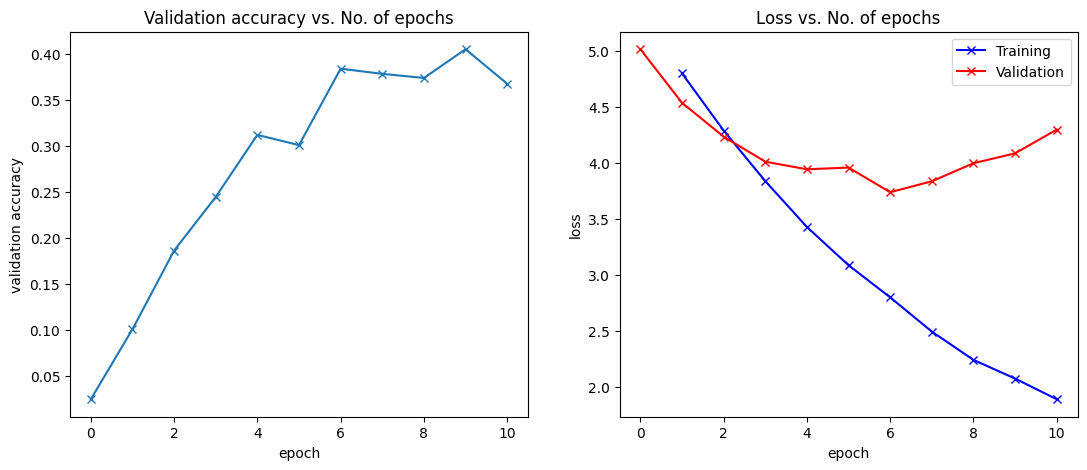

In [ ]:
plot_all(history)

In [ ]:
# Testing accuracy
evaluate_test(model, test_loader)

{'test_loss': 4.122418403625488, 'test_acc': 0.3880208432674408}

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


In [ ]:
# Ratio of the testing accuracy (in %) to Gflops in Baseline model
print('The best testing accuracy is: ', 38.8,'%')
print('The efficiency is: ',round(38.8/0.69), '% per Gflops')

The best testing accuracy is:  38.8 %
The efficiency is:  56 % per Gflops


# Baseline model (Changing the learning rate and number of epochs)

### Num_epochs=10, learning rate = 0.0001

Epoch [9], train_loss: 1.7464, val_loss: 3.7561, val_acc: 0.4590


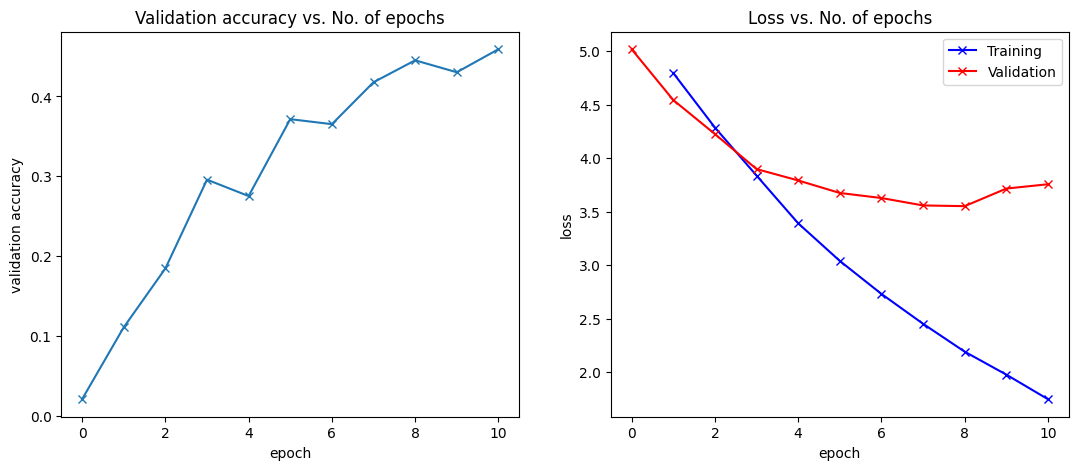

{'test_loss': 3.895864963531494, 'test_acc': 0.42239585518836975}

In [ ]:
#  lr=0.0001
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

### Num_epochs=10, learning rate = 0.01

Epoch [9], train_loss: 4.9972, val_loss: 5.0124, val_acc: 0.0125


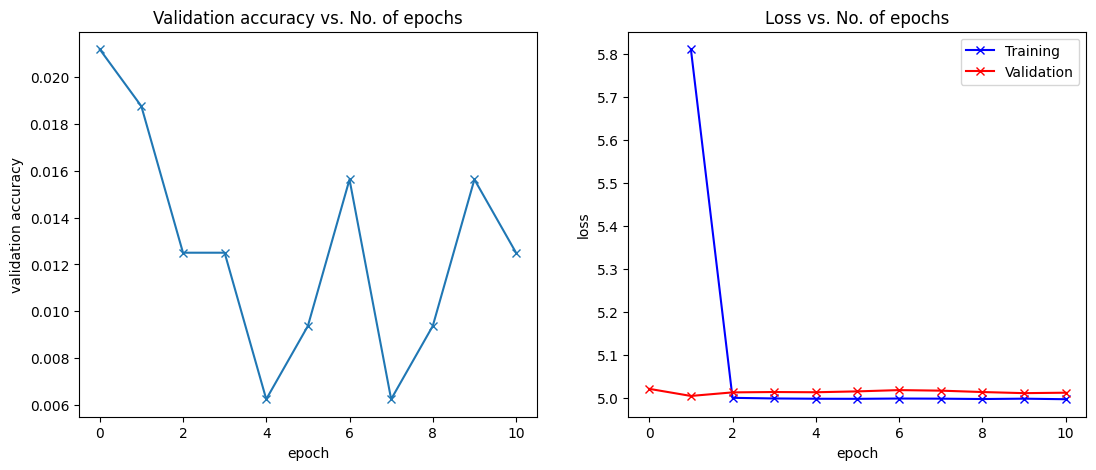

{'test_loss': 5.025878429412842, 'test_acc': 0.015625}

In [ ]:
#  lr=0.01
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=10, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(model, test_loader)

### num_epochs = 30, learning rate = 0.0001

Epoch [29], train_loss: 0.1940, val_loss: 7.1344, val_acc: 0.4865


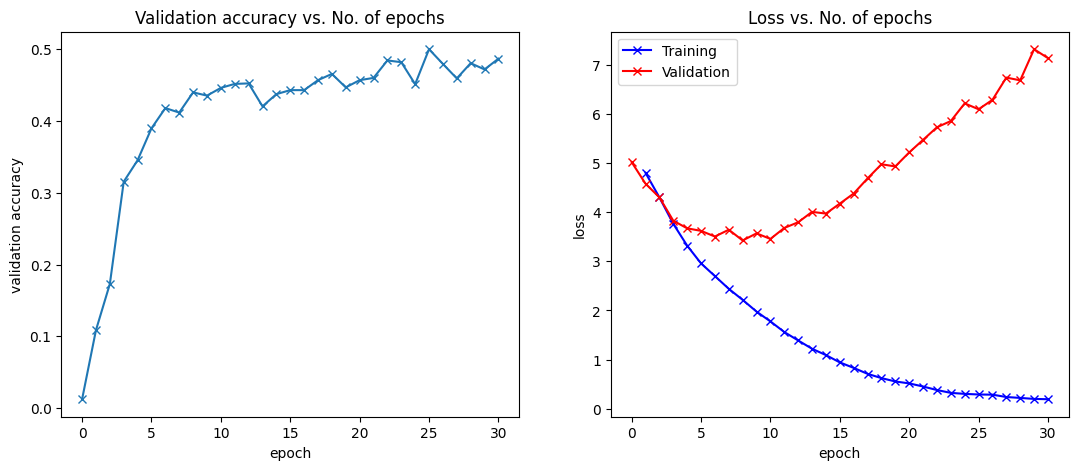

{'test_loss': 7.3639373779296875, 'test_acc': 0.47447919845581055}

In [ ]:
#  num_epochs = 30, lr = 0.0001
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=30, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

### num_epochs = 30, learning rate = 0.001

Epoch [29], train_loss: 0.6100, val_loss: 7.0825, val_acc: 0.4184


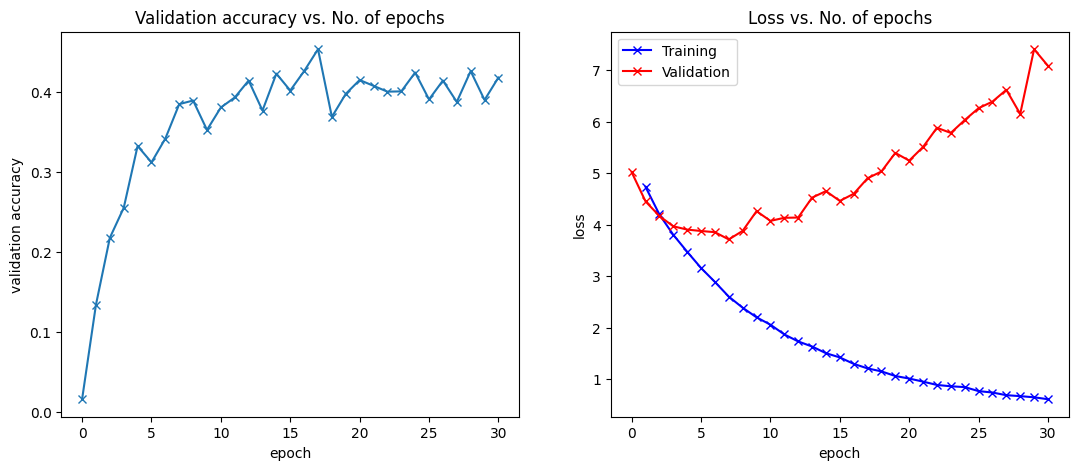

{'test_loss': 6.900067329406738, 'test_acc': 0.4036458432674408}

In [ ]:
#  num_epochs = 30, lr = 0.001
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=30, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(model, test_loader)

### num_epochs = 30, learning rate = 0.01

Epoch [29], train_loss: 4.9983, val_loss: 5.0128, val_acc: 0.0125


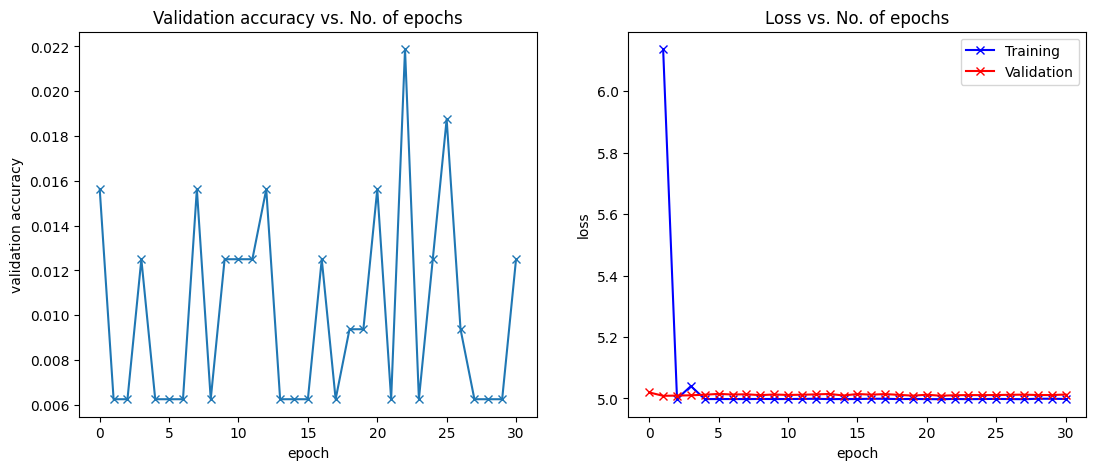

{'test_loss': 5.025290012359619, 'test_acc': 0.01875000074505806}

In [ ]:
#  num_epochs = 30, lr = 0.01
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=30, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(model, test_loader)

### num_epochs = 50, learning rate = 0.0001

Epoch [49], train_loss: 0.0811, val_loss: 9.0716, val_acc: 0.4747


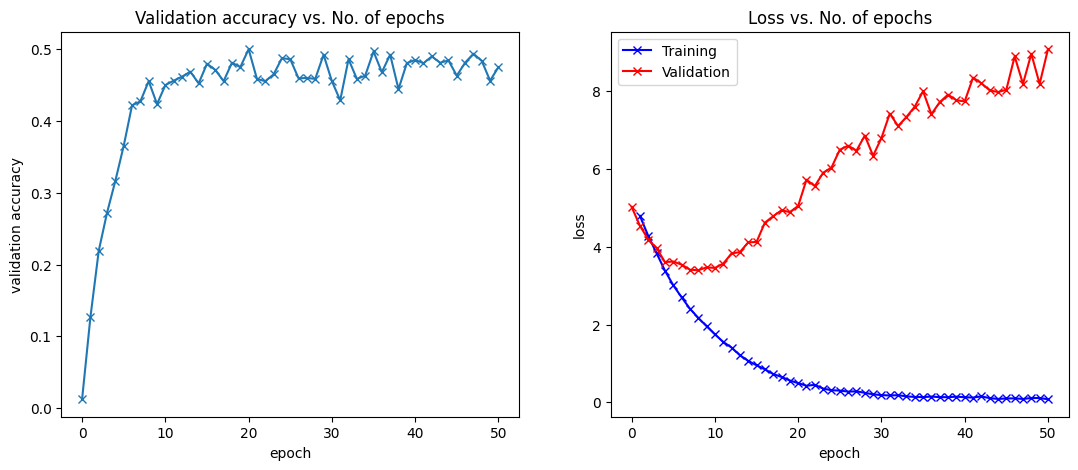

{'test_loss': 9.0043363571167, 'test_acc': 0.45729169249534607}

In [ ]:
#  num_epochs=50, lr=0.0001
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

### num_epochs = 50, learning rate = 0.001

Epoch [49], train_loss: 0.2627, val_loss: 9.6130, val_acc: 0.4316


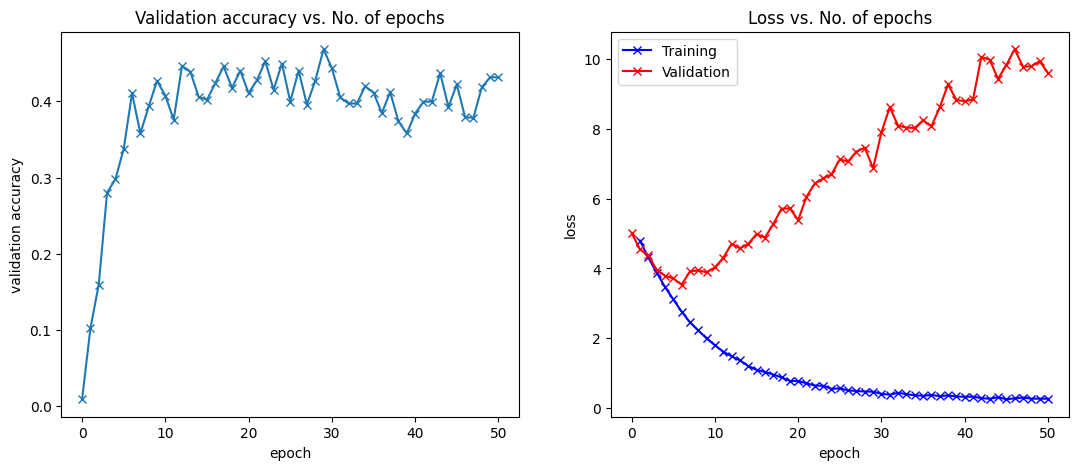

{'test_loss': 9.783281326293945, 'test_acc': 0.413541704416275}

In [ ]:
#  num_epochs=50, lr=0.001
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(model, test_loader)

### num_epochs = 50, learning rate = 0.01

Epoch [49], train_loss: 4.9974, val_loss: 5.0129, val_acc: 0.0125


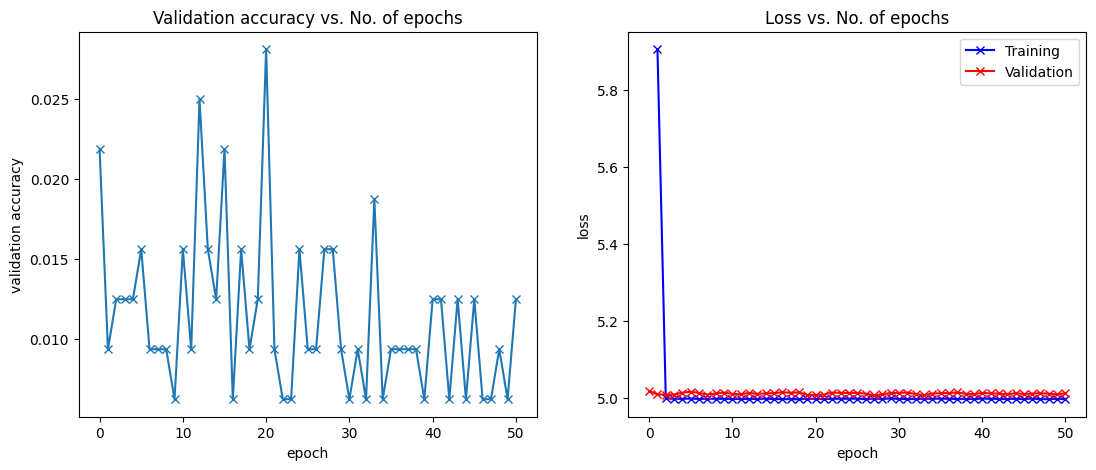

{'test_loss': 5.026828765869141, 'test_acc': 0.015625}

In [ ]:
#  num_epochs=50, lr=0.01
model = ConvolutionalNetwork(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(model, test_loader)

In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Baseline model (Changing the learning rate and number of epochs)
print('The best testing accuracy is: ', 47.4,'%')
print('The efficiency is: ',round(47.4/0.69), '% per Gflops')

The best testing accuracy is:  47.4 %
The efficiency is:  69 % per Gflops


# Baseline Model add dropout and batch Norm

In [ ]:
# Convolutional Network - Baseline add dropout and batch Norm
class CNN_drop_norm(ImageClassificationBase):
    def __init__(self, classes, dropout_rate=0.5):
        super().__init__()
        self.num_classes=classes
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 3, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, self.num_classes)

    def forward(self,X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, 128 * 5 * 5)

        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=self.dropout_rate, training=self.training)
        X = self.fc2(X)

        return F.log_softmax(X, dim=1)

### Dropout, batch normalisation, number of epochs = 10

Epoch [9], train_loss: 3.9440, val_loss: 3.7307, val_acc: 0.3115


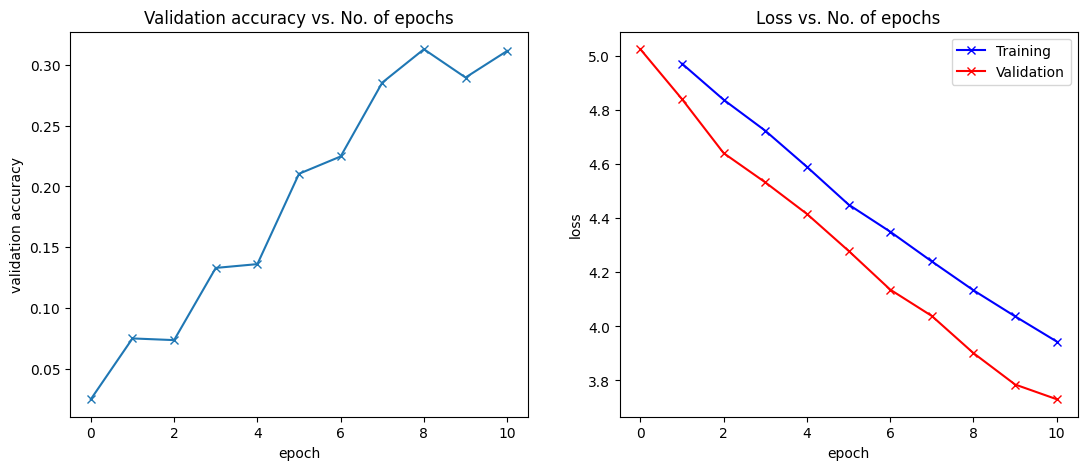

{'test_loss': 3.7014408111572266, 'test_acc': 0.33281251788139343}

In [ ]:
# dropout, batch norm added
model = CNN_drop_norm(num_classes)
train_validate(model=model, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

### Dropout, batch normalisation, number of epochs = 30

Epoch [29], train_loss: 2.8356, val_loss: 2.8006, val_acc: 0.5413


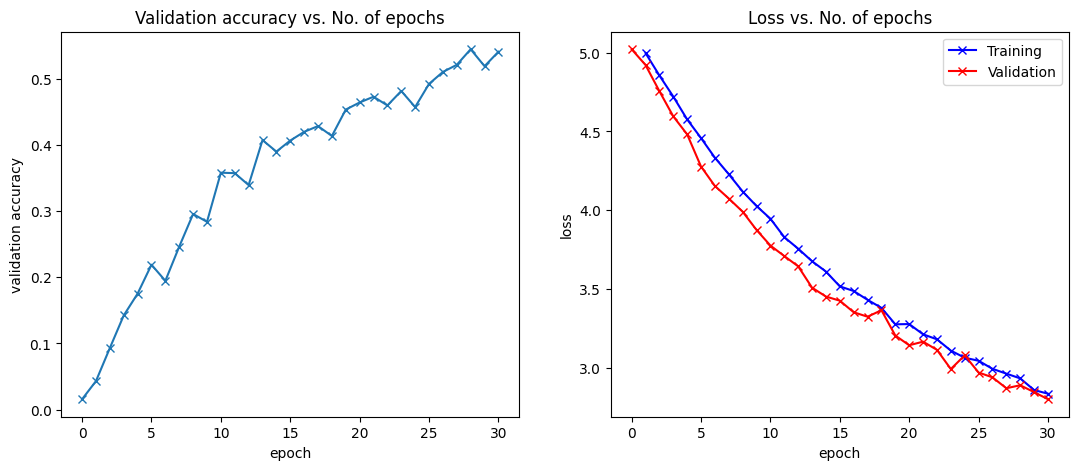

{'test_loss': 2.7120044231414795, 'test_acc': 0.5677083730697632}

In [ ]:
# dropout, batch norm added
model = CNN_drop_norm(num_classes)
train_validate(model=model, num_epochs=30, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

### Dropout, batch normalisation, number of epochs = 50

Epoch [49], train_loss: 2.4170, val_loss: 2.7444, val_acc: 0.5528


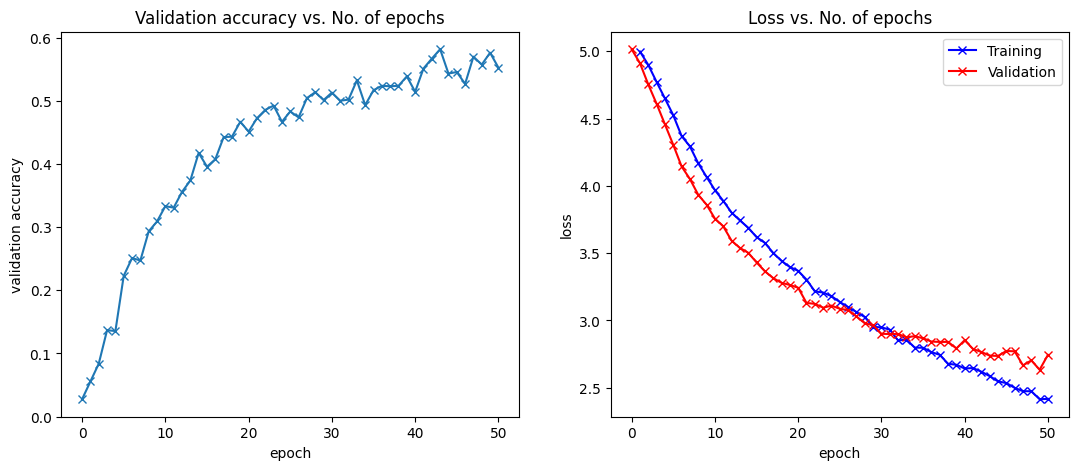

{'test_loss': 2.5394484996795654, 'test_acc': 0.5817708373069763}

In [ ]:
# num_epochs=50
model = CNN_drop_norm(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
model = CNN_drop_norm(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Baseline Model add dropout and batch Norm
print('The best testing accuracy is: ', 58.2,'%')
print('The efficiency is: ',round(58.2/0.69), '% per Gflops')

The best testing accuracy is:  58.2 %
The efficiency is:  84 % per Gflops


# Baseline Model (dropout and batch Norm) with different optimizers


### Optimizer = SGD, number of ephocs = 50, learning rate = 0.0001

Epoch [49], train_loss: 4.8186, val_loss: 4.8063, val_acc: 0.1205


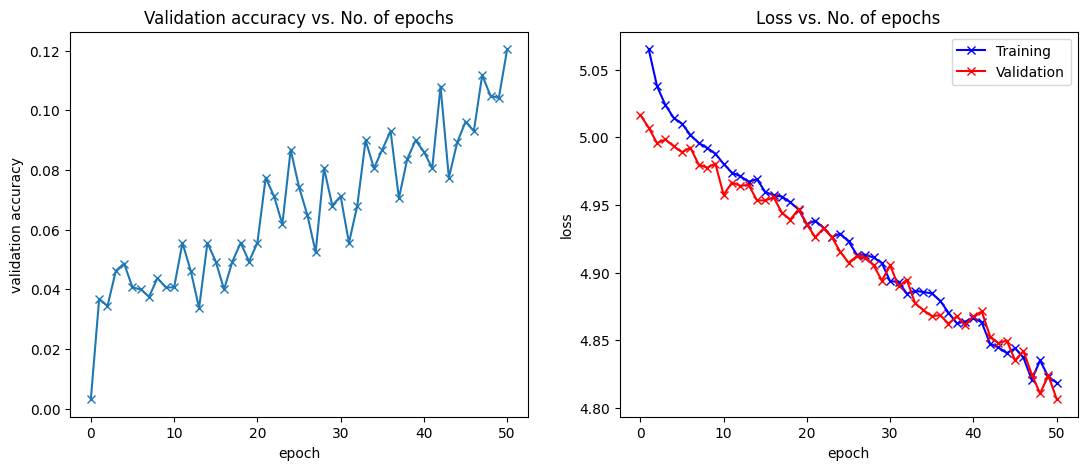

{'test_loss': 4.800591468811035, 'test_acc': 0.11874999850988388}

In [ ]:
# opt_func=torch.optim.SGD
model = CNN_drop_norm(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.SGD, lr=0.0001)
evaluate_test(model, test_loader)

### Optimizer = RMSprop, number of ephocs = 50, learning rate = 0.0001

Epoch [49], train_loss: 2.4967, val_loss: 2.8035, val_acc: 0.4958


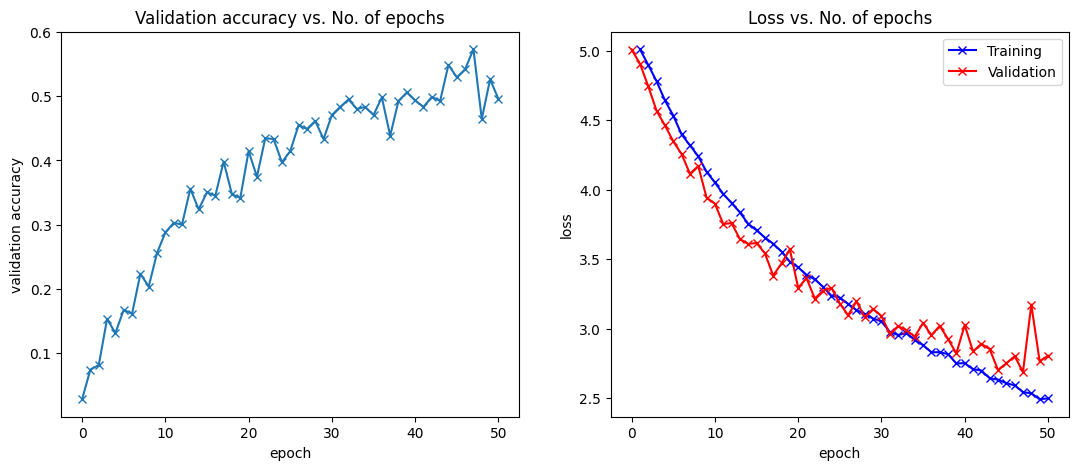

{'test_loss': 2.7452123165130615, 'test_acc': 0.5505208373069763}

In [ ]:
# opt_func=torch.optim.RMSprop
model = CNN_drop_norm(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.RMSprop, lr=0.0001)
evaluate_test(model, test_loader)

In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Baseline Model add dropout and batch Norm for different optimizers
print('The best testing accuracy is: ', 58.2,'%')
print('The efficiency is: ',round(58.2/0.69), '% per Gflops')

The best testing accuracy is:  58.2 %
The efficiency is:  84 % per Gflops


# Deeper Baseline Model
- optimizer = Adam
- number of ephocs = 50
- learning rate = 0.0001
- dropout
- batch normalisation

In [ ]:
class CNN_drop_norm_deep(ImageClassificationBase):
    def __init__(self, classes, dropout_rate=0.5):
        super().__init__()
        self.num_classes = classes
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, 1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.fc1 = nn.Linear(1024 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn5(self.conv5(X)))

        X = X.view(-1, 1024 * 3 * 3)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)


Epoch [49], train_loss: 0.8122, val_loss: 2.7677, val_acc: 0.5944


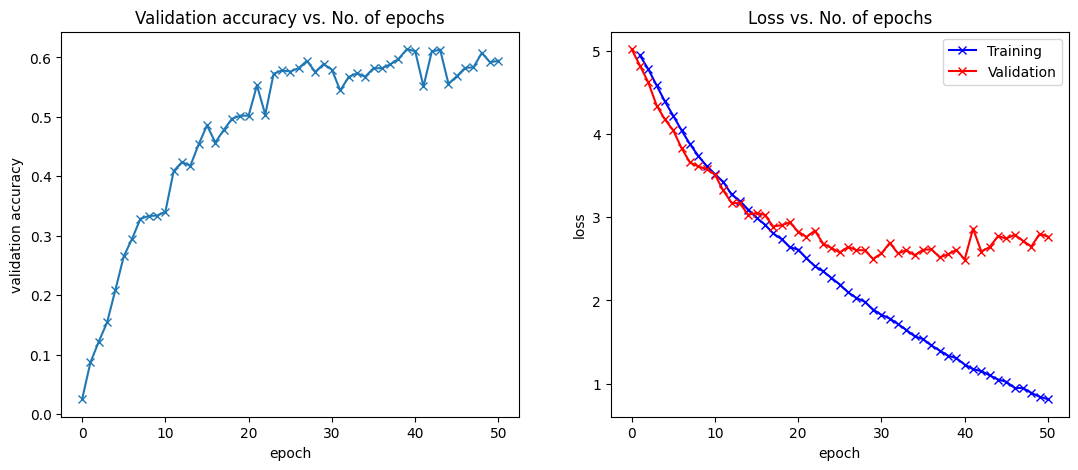

{'test_loss': 2.545799493789673, 'test_acc': 0.6432291865348816}

In [ ]:
model = CNN_drop_norm_deep(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
model = CNN_drop_norm_deep(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 1.16G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Deeper Baseline Model
print('The best testing accuracy is: ', 64.3,'%')
print('The efficiency is: ',round(64.3/1.16), '% per Gflops')

The best testing accuracy is:  64.3 %
The efficiency is:  55 % per Gflops


# Wider and Deeper Baseline Model
- optimizer = Adam
- number of ephocs = 50
- learning rate = 0.0001
- dropout
- batch normalisation

In [ ]:
class Wider_deeper_CNN_drop_norm(ImageClassificationBase):
    def __init__(self, classes, dropout_rate=0.5):
        super().__init__()
        self.num_classes = classes
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(3, 128, 5, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 3, 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 3, 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 3, 1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 2048, 3, 1)
        self.bn5 = nn.BatchNorm2d(2048)

        self.fc1 = nn.Linear(2048 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, self.num_classes)

        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn5(self.conv5(X)))

        X = X.view(-1, 2048 * 3 * 3)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.dropout(X)
        X = self.fc4(X)

        return F.log_softmax(X, dim=1)


Epoch [49], train_loss: 0.9520, val_loss: 2.7157, val_acc: 0.5889


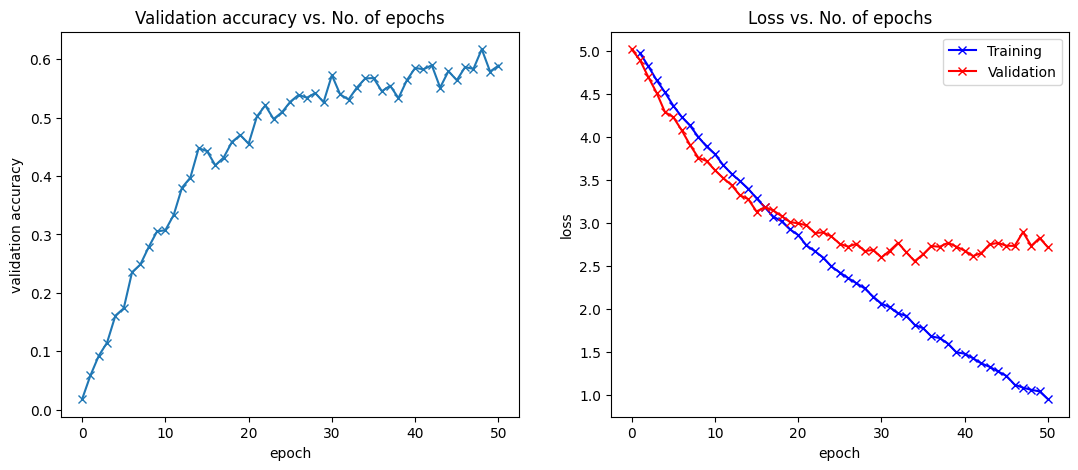

{'test_loss': 2.5997586250305176, 'test_acc': 0.6213542222976685}

In [ ]:
model = Wider_deeper_CNN_drop_norm(num_classes)
train_validate(model=model, num_epochs=50, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(model, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
model = Wider_deeper_CNN_drop_norm(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 4.45G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Deeper Baseline Model
print('The best testing accuracy is: ', 62.1,'%')
print('The efficiency is: ',round(62.1/4.45), '% per Gflops')

The best testing accuracy is:  62.1 %
The efficiency is:  14 % per Gflops


# Transfer learning: Pre-trained ResNet

### Pre-train ResNet50
- optimizer = Adam
- number of ephocs = 10

In [ ]:
class Pre_ResNet_50(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        # Use a pretrained model
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(in_features=2048, out_features=self.num_classes)

    def forward(self, x):
        return self.backbone(x)

#### learning rate = 0.0001

Epoch [9], train_loss: 0.2105, val_loss: 1.1548, val_acc: 0.8906


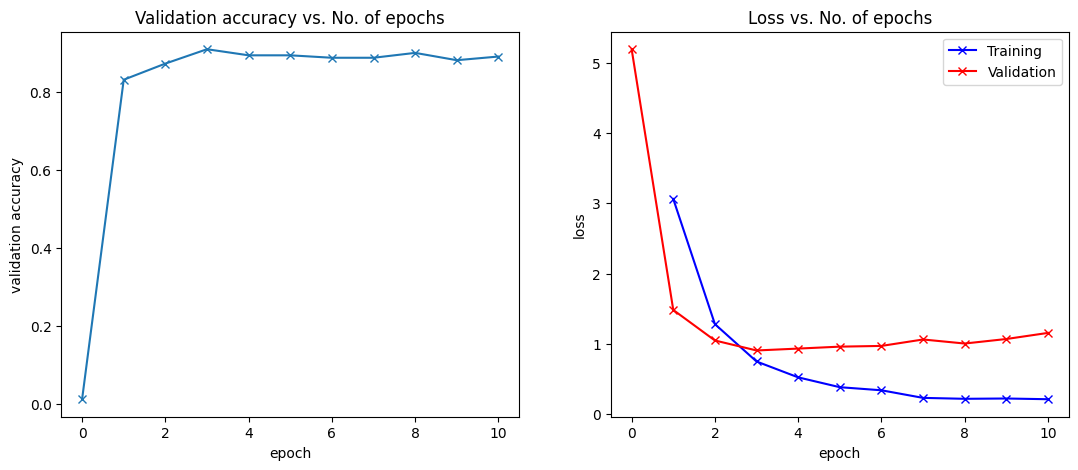

{'test_loss': 1.0169981718063354, 'test_acc': 0.8921875357627869}

In [ ]:
# lr = 0.0001
Pre_ResNet_50 = Pre_ResNet_50(num_classes)
Pre_ResNet_50.to(device)
train_validate(model=Pre_ResNet_50, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(Pre_ResNet_50, test_loader)

#### learning rate = 0.001

Epoch [9], train_loss: 3.0671, val_loss: 3.2496, val_acc: 0.4340


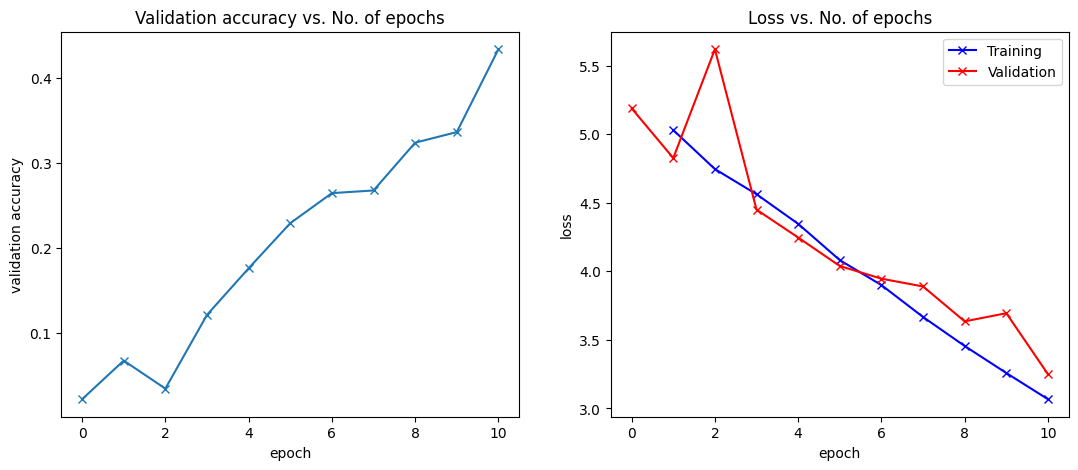

{'test_loss': 3.2232396602630615, 'test_acc': 0.4364583492279053}

In [ ]:
# lr = 0.001
Pre_ResNet_50 = Pre_ResNet_50(num_classes)
Pre_ResNet_50.to(device)
train_validate(model=Pre_ResNet_50, num_epochs=10, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(Pre_ResNet_50, test_loader)

#### learning rate = 0.01

Epoch [9], train_loss: 4.2434, val_loss: 4.3037, val_acc: 0.1785


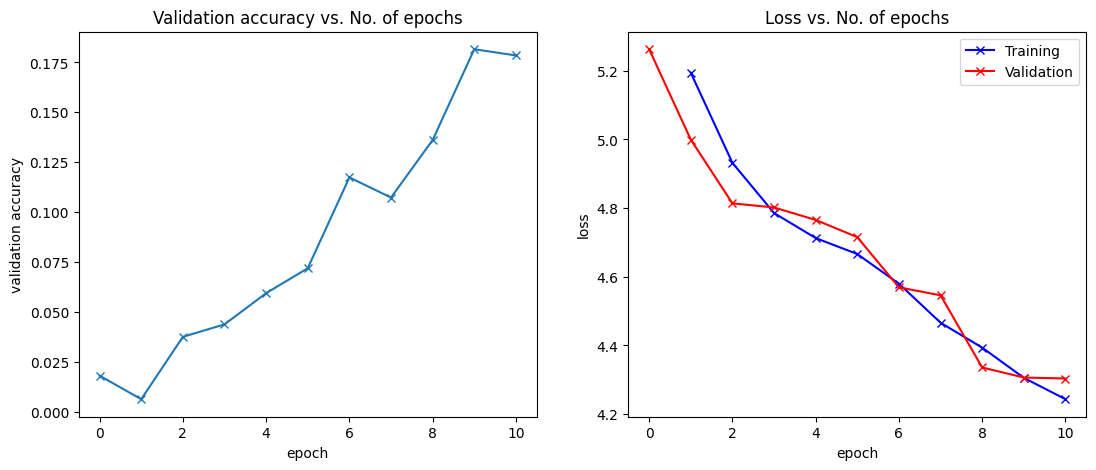

{'test_loss': 4.231194972991943, 'test_acc': 0.15000000596046448}

In [ ]:
# lr = 0.01
Pre_ResNet_50 = Pre_ResNet_50(num_classes)
Pre_ResNet_50.to(device)
train_validate(model=Pre_ResNet_50, num_epochs=10, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(Pre_ResNet_50, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
Pre_ResNet_50 = Pre_ResNet_50(num_classes)
print_model_parm_flops(Pre_ResNet_50, input, detail=False)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


 + Number of FLOPs: 2.15G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Pre-trained ResNet 50 Model
print('The best testing accuracy is: ', 89.2,'%')
print('The efficiency is: ',round(89.2/2.15), '% per Gflops')

The best testing accuracy is:  89.2 %
The efficiency is:  41 % per Gflops


### Pre-train ResNet101
- optimizer = Adam
- number of ephocs = 10

In [ ]:
class Pre_ResNet_101(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        # Use a pretrained model
        self.backbone = models.resnet101(pretrained=True)
        self.backbone.fc = nn.Linear(in_features=2048, out_features=self.num_classes)

    def forward(self, x):
        return self.backbone(x)

#### learning rate = 0.0001

Epoch [9], train_loss: 0.2256, val_loss: 1.1726, val_acc: 0.8781


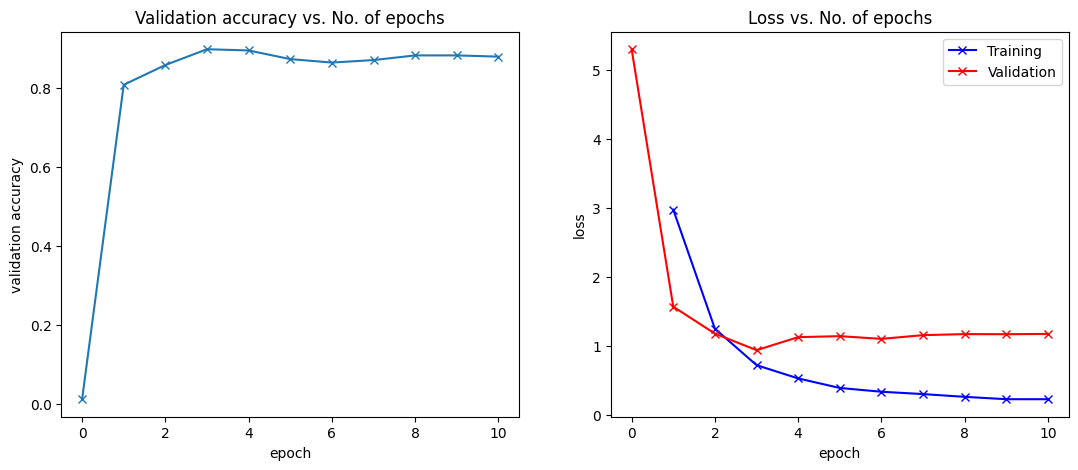

{'test_loss': 1.3238445520401, 'test_acc': 0.8713542222976685}

In [ ]:
# lr = 0.0001
Pre_ResNet_101 = Pre_ResNet_101(num_classes)
Pre_ResNet_101.to(device)
train_validate(model=Pre_ResNet_101, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(Pre_ResNet_101, test_loader)

#### learning rate = 0.001

Epoch [9], train_loss: 2.9592, val_loss: 3.2776, val_acc: 0.4295


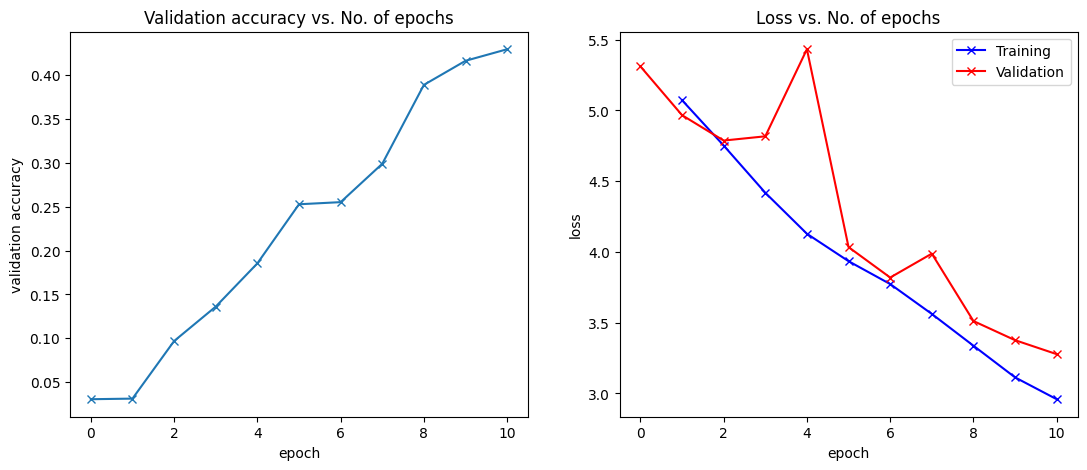

{'test_loss': 3.1022965908050537, 'test_acc': 0.44583335518836975}

In [ ]:
# lr = 0.001
Pre_ResNet_101 = Pre_ResNet_101(num_classes)
Pre_ResNet_101.to(device)
train_validate(model=Pre_ResNet_101, num_epochs=10, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(Pre_ResNet_101, test_loader)

#### learning rate = 0.01

Epoch [9], train_loss: 4.6865, val_loss: 4.6667, val_acc: 0.0625


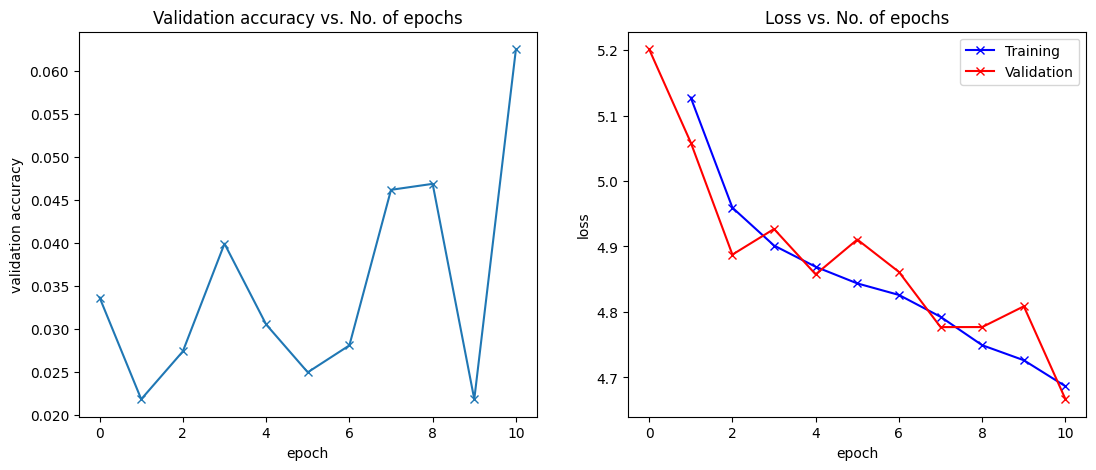

{'test_loss': 4.6775102615356445, 'test_acc': 0.0703125}

In [ ]:
# lr = 0.01
Pre_ResNet_101 = Pre_ResNet_101(num_classes)
Pre_ResNet_101.to(device)
train_validate(model=Pre_ResNet_101, num_epochs=10, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(Pre_ResNet_101, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
Pre_ResNet_101 = Pre_ResNet_101(num_classes)
print_model_parm_flops(Pre_ResNet_101, input, detail=False)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:09<00:00, 18.3MB/s]


 + Number of FLOPs: 4.01G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Pre-trained ResNet 101 Model
print('The best testing accuracy is: ', 87.1,'%')
print('The efficiency is: ',round(87.1/4.01), '% per Gflops')

The best testing accuracy is:  87.1 %
The efficiency is:  22 % per Gflops


### Pre-train ResNet152
- optimizer = Adam
- number of ephocs = 10

In [ ]:
class Pre_ResNet_152(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        # Use a pretrained model
        self.backbone = models.resnet152(pretrained=True)
        self.backbone.fc = nn.Linear(in_features=2048, out_features=self.num_classes)

    def forward(self, x):
        return self.backbone(x)

#### learning rate = 0.0001

Epoch [9], train_loss: 0.2214, val_loss: 1.1955, val_acc: 0.8781


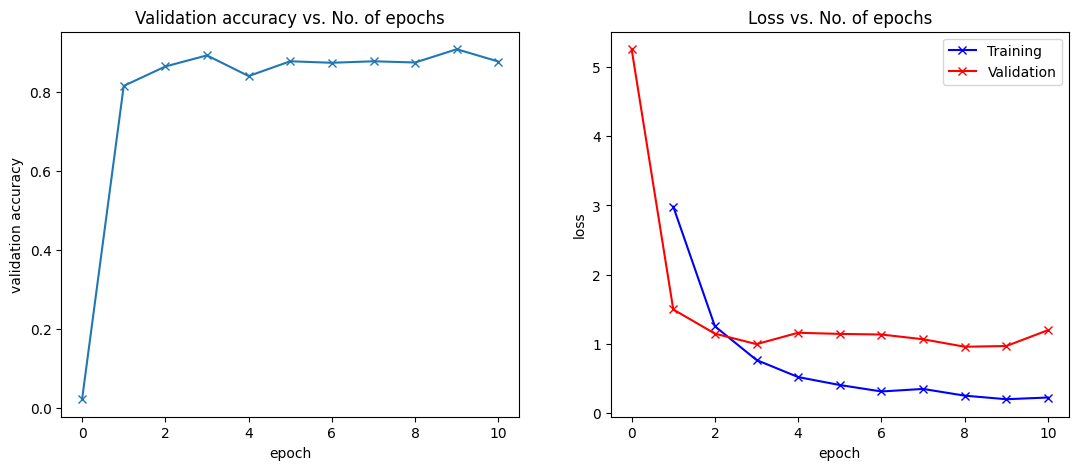

{'test_loss': 1.1796430349349976, 'test_acc': 0.8651041984558105}

In [ ]:
# lr = 0.0001
Pre_ResNet_152 = Pre_ResNet_152(num_classes)
Pre_ResNet_152.to(device)
train_validate(model=Pre_ResNet_152, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(Pre_ResNet_152, test_loader)

#### learning rate = 0.001

Epoch [9], train_loss: 2.5619, val_loss: 2.9757, val_acc: 0.4747


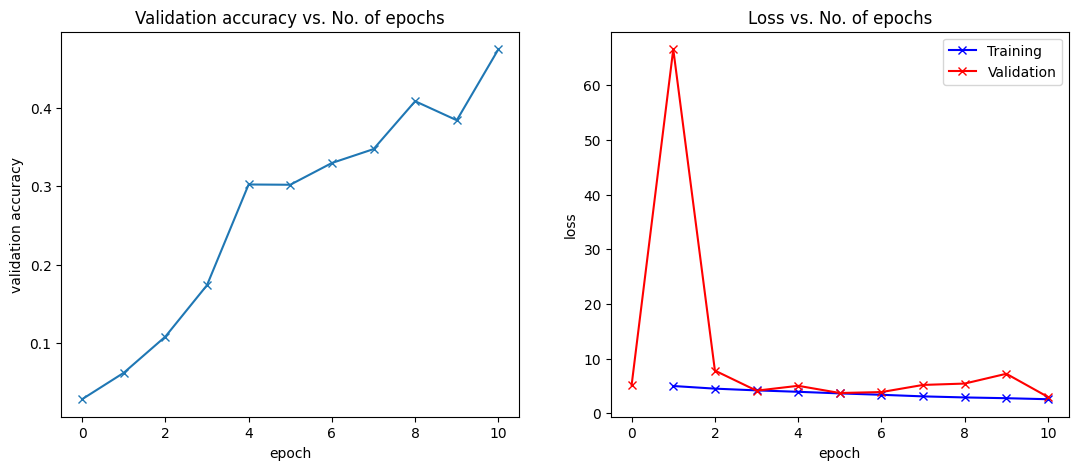

{'test_loss': 2.777583122253418, 'test_acc': 0.5380208492279053}

In [ ]:
# lr = 0.001
Pre_ResNet_152 = Pre_ResNet_152(num_classes)
Pre_ResNet_152.to(device)
train_validate(model=Pre_ResNet_152, num_epochs=10, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(Pre_ResNet_152, test_loader)

#### learning rate = 0.01

Epoch [9], train_loss: 4.7829, val_loss: 4.7880, val_acc: 0.0312


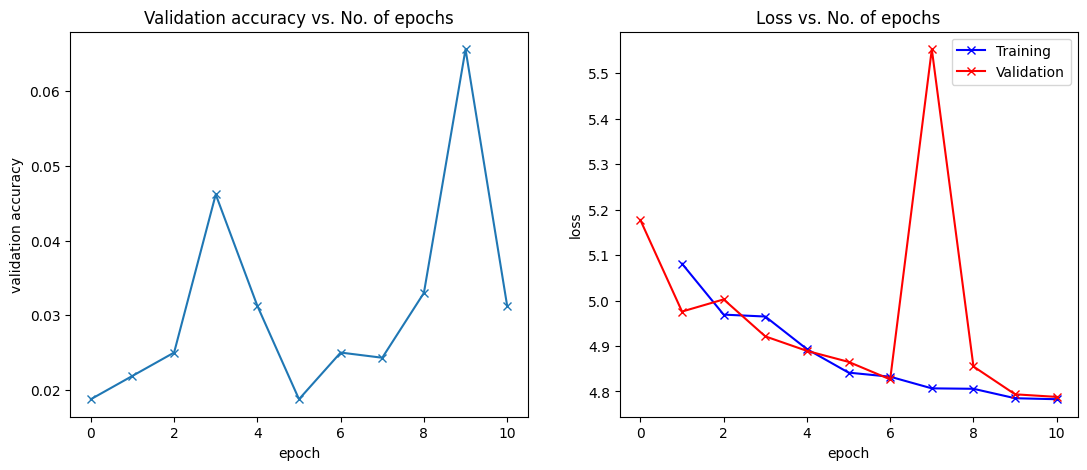

{'test_loss': 4.74934196472168, 'test_acc': 0.04062500223517418}

In [ ]:
# lr = 0.01
Pre_ResNet_152 = Pre_ResNet_152(num_classes)
Pre_ResNet_152.to(device)
train_validate(model=Pre_ResNet_152, num_epochs=10, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(Pre_ResNet_152, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
Pre_ResNet_152 = Pre_ResNet_152(num_classes)
print_model_parm_flops(Pre_ResNet_152, input, detail=False)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:05<00:00, 44.6MB/s]


 + Number of FLOPs: 5.87G


In [1]:
# Ratio of the best testing accuracy (in %) to Gflops in Pre-trained ResNet 152 Model
print('The best testing accuracy is: ', 86.5,'%')
print('The efficiency is: ',round(86.5/5.87), '% per Gflops')

The best testing accuracy is:  86.5 %
The efficiency is:  15 % per Gflops


# Transfer Learning: MobileNet model

###  MobileNet_v2
- optimizer = Adam
- number of ephocs = 10

In [ ]:
import torchvision.models as models
class MobileNet_v2(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.backbone = models.mobilenet_v2(pretrained=True)
        # Adjust input size to match (3, 112, 112)
        self.backbone.classifier[1] = nn.Linear(in_features=self.backbone.classifier[1].in_features, out_features=self.num_classes)

    def forward(self,X):
        return self.backbone(X)


#### learning rate = 0.0001

Epoch [9], train_loss: 0.2288, val_loss: 0.8835, val_acc: 0.9031


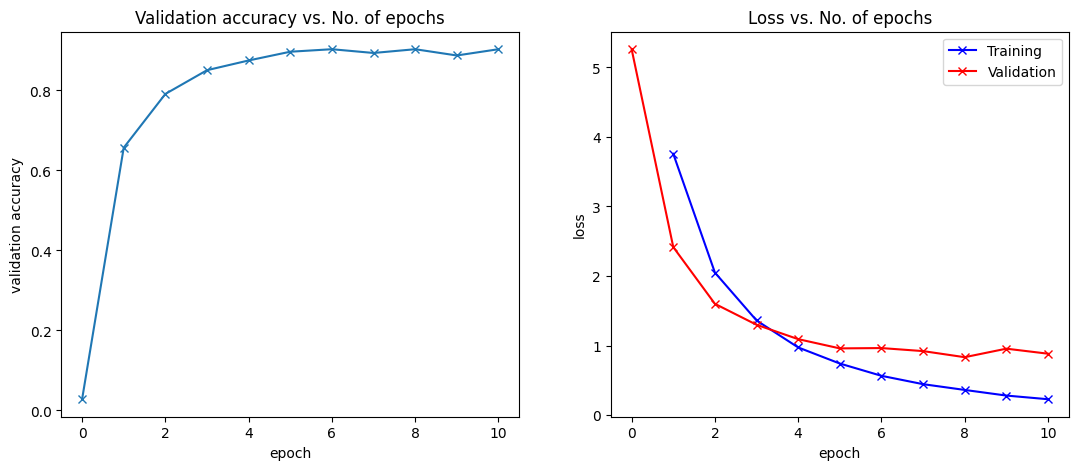

{'test_loss': 0.9288752675056458, 'test_acc': 0.8869792222976685}

In [ ]:
# lr = 0.0001
MobileNet_v2 = MobileNet_v2(num_classes)
MobileNet_v2.to(device)
train_validate(model=MobileNet_v2, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(MobileNet_v2, test_loader)

#### learning rate = 0.001

Epoch [9], train_loss: 1.5372, val_loss: 1.8837, val_acc: 0.7351


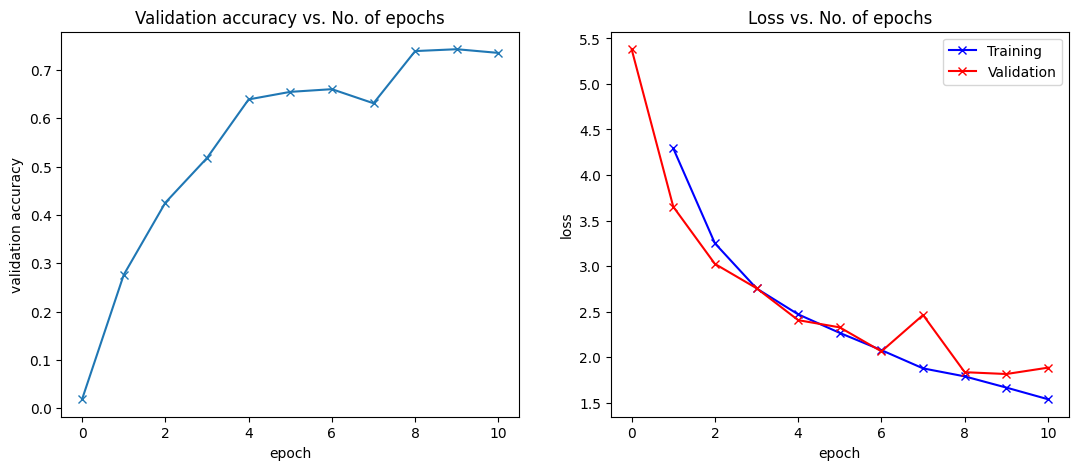

{'test_loss': 2.0412189960479736, 'test_acc': 0.6927083730697632}

In [ ]:
# lr = 0.001
MobileNet_v2 = MobileNet_v2(num_classes)
MobileNet_v2.to(device)
train_validate(model=MobileNet_v2, num_epochs=10, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(MobileNet_v2, test_loader)

#### learning rate = 0.01

Epoch [9], train_loss: 4.7826, val_loss: 4.8313, val_acc: 0.0344


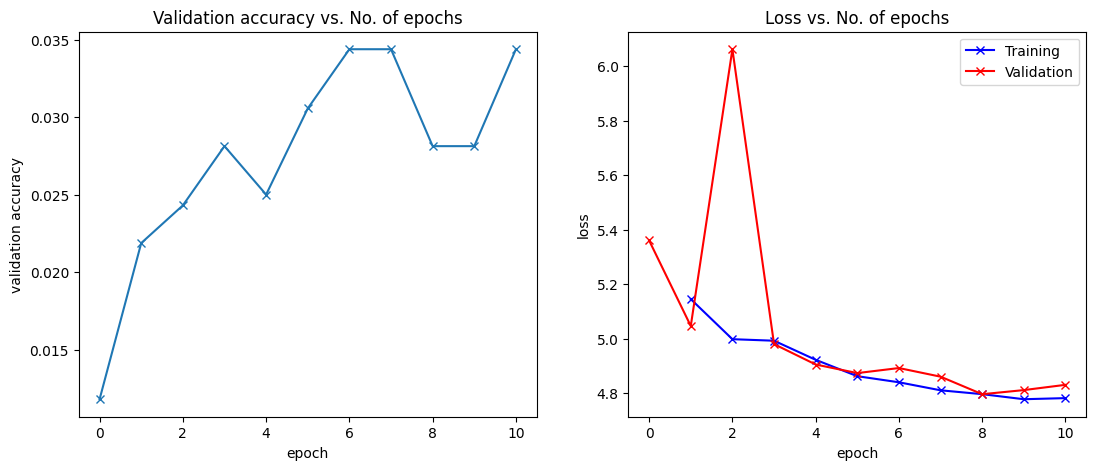

{'test_loss': 4.80126953125, 'test_acc': 0.04218750074505806}

In [ ]:
# lr = 0.01
MobileNet_v2 = MobileNet_v2(num_classes)
MobileNet_v2.to(device)
train_validate(model=MobileNet_v2, num_epochs=10, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(MobileNet_v2, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
MobileNet_v2 = MobileNet_v2(num_classes)
print()
print_model_parm_flops(MobileNet_v2, input, detail=False)


 + Number of FLOPs: 0.16G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Pre-trained MobileNet_v2 model
print('The best testing accuracy is: ', 88.7,'%')
print('The efficiency is: ',round(88.7/0.16), '% per Gflops')

The best testing accuracy is:  88.7 %
The efficiency is:  554 % per Gflops


###  MobileNet_v3
- optimizer = Adam
- number of ephocs = 10

In [ ]:
# Convolutional Network - MobileNet_v3
class MobileNet_v3(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        # Use a pretrained model
        self.backbone = models.mobilenet_v3_large(pretrained=True)
        self.backbone.classifier[3] = nn.Linear(in_features=self.backbone.classifier[3].in_features, out_features=self.num_classes)

    def forward(self, x):
        return self.backbone(x)

#### learning rate = 0.0001

Epoch [9], train_loss: 0.1902, val_loss: 1.0042, val_acc: 0.8906


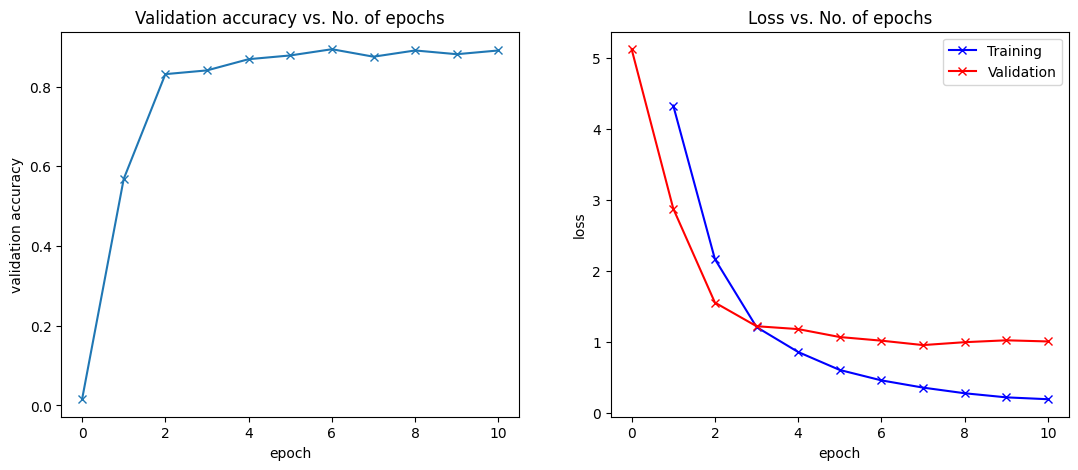

{'test_loss': 0.8912464380264282, 'test_acc': 0.9026042222976685}

In [ ]:
# lr = 0.0001
MobileNet_v3 = MobileNet_v3(num_classes)
MobileNet_v3.to(device)
train_validate(model=MobileNet_v3, num_epochs=10, opt_func=torch.optim.Adam, lr=0.0001)
evaluate_test(MobileNet_v2, test_loader)

#### learning rate = 0.001

Epoch [9], train_loss: 0.4774, val_loss: 2.3029, val_acc: 0.7851


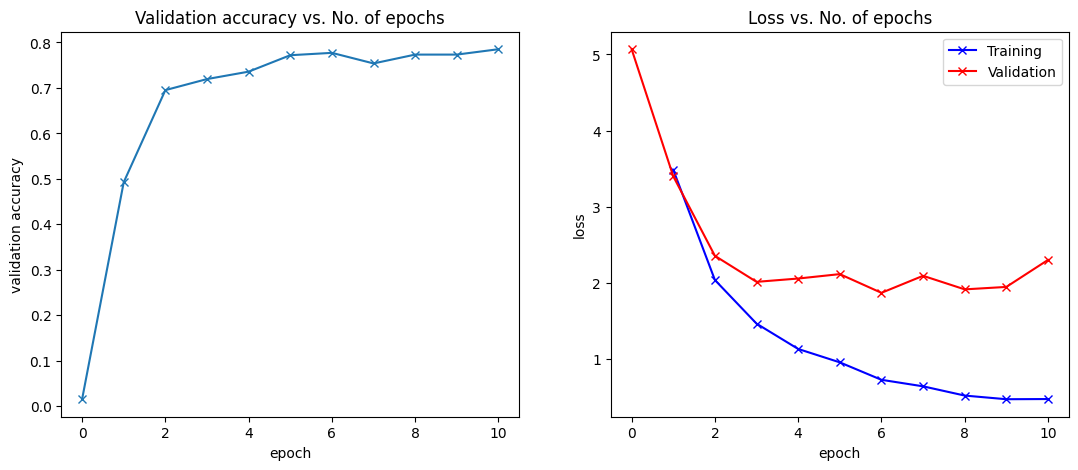

{'test_loss': 2.029388427734375, 'test_acc': 0.7005208730697632}

In [ ]:
# lr = 0.001
MobileNet_v3 = MobileNet_v3(num_classes)
MobileNet_v3.to(device)
train_validate(model=MobileNet_v3, num_epochs=10, opt_func=torch.optim.Adam, lr=0.001)
evaluate_test(MobileNet_v2, test_loader)

#### learning rate = 0.01

Epoch [9], train_loss: 4.9990, val_loss: 5.0100, val_acc: 0.0125


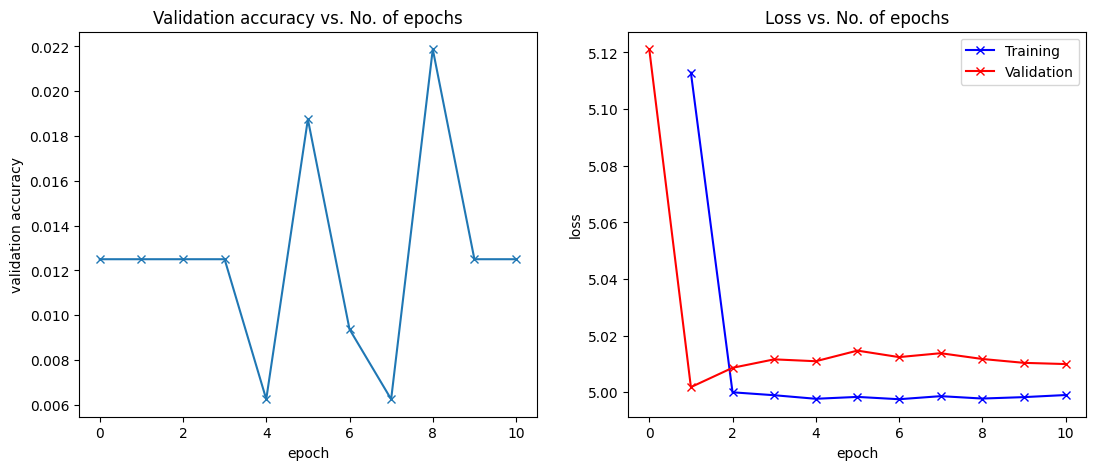

{'test_loss': 4.798820495605469, 'test_acc': 0.04531250149011612}

In [ ]:
# lr = 0.01
MobileNet_v3 = MobileNet_v3(num_classes)
MobileNet_v3.to(device)
train_validate(model=MobileNet_v3, num_epochs=10, opt_func=torch.optim.Adam, lr=0.01)
evaluate_test(MobileNet_v2, test_loader)

In [ ]:
input = torch.randn(1, 3, 112, 112)
num_classes = 151
MobileNet_v3 = MobileNet_v3(num_classes)
print()
print_model_parm_flops(MobileNet_v3, input, detail=False)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:03<00:00, 7.22MB/s]


 + Number of FLOPs: 0.12G


In [ ]:
# Ratio of the best testing accuracy (in %) to Gflops in Pre-trained MobileNet_v2 model
print('The best testing accuracy is: ', 90.3,'%')
print('The efficiency is: ',round(90.3/0.12), '% per Gflops')

The best testing accuracy is:  90.3 %
The efficiency is:  752 % per Gflops
